In [39]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
import lifelines

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import pearsonr, spearmanr, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [40]:
### STATS ###
import statsmodels.stats.multitest as multi
from matplotlib.collections import PatchCollection

In [41]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get survival information

In [42]:
def make_df(surv,surv_type,raw):
    #get survival dataframe
    surv=pd.read_csv(surv,index_col=0)
    surv=surv.rename(columns={"bcr_patient_barcode":"FID"})
    #get genotypes
    snps=pd.read_csv(raw,delimiter=" ")
    cols=[x for x in snps.columns if x not in ["IID","PAT","MAT","SEX","PHENOTYPE"]]
    snps=snps[cols]
    #combine dataframes
    full_surv=pd.merge(surv[["FID",surv_type,surv_type+".time"]],snps,on="FID")
    print(full_surv.shape)
    full_surv=full_surv[full_surv[surv_type+".time"]<1825]
    return(full_surv)

In [43]:
os_surv=make_df("/cellar/users/mpagadal/Data/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","OS","/nrnb/users/mpagadal/tcga-genotypes/germline-immune/all.snp.raw")

(8183, 525)


## Map to cancer types

In [44]:
# map to cancer type
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
os_surv["cancer"]=os_surv["FID"].map(mp)

In [45]:
rsid_lst=os_surv.columns[3:-1]

In [46]:
# make list of cancer types
cancers=os_surv["cancer"].unique().tolist()

## Run Kaplan-Meier analysis

In [47]:
def run_surv(df,surv_type,rsid,cancers):
    snp=[]
    logrank=[]
    cancer=[]
    min_group=[]
    maj_group=[]

    for y in cancers:
        for x in rsid_lst:
            try:
                full_surv_canc=df[df["cancer"]==y]
            
                rs=x.rsplit(":",2)[0]
                allele=x.split(":")[3]
                minor=allele.split("_")[1]
                major=allele.split("_")[0]
            
                groups = full_surv_canc[x]
                ix = (groups == 2)

                results = logrank_test(full_surv_canc[surv_type+'.time'][ix], full_surv_canc[surv_type+'.time'][~ix],event_observed_A=full_surv_canc[surv_type][ix], event_observed_B=full_surv_canc[surv_type][~ix], alpha=.95) 
        
                snp.append(x)
                logrank.append(results.p_value)
                cancer.append(y)
                min_group.append(len(full_surv_canc[surv_type+'.time'][ix]))
                maj_group.append(len(full_surv_canc[surv_type+'.time'][~ix]))
        
            except:
                pass
        
    os=pd.DataFrame({"snps":snp,"os.time":logrank,"cancer":cancer,"min":min_group,"maj":maj_group})
    return(os)

In [48]:
os=run_surv(os_surv,"OS",rsid_lst,cancers)

### Filter for curves with at least 1 patient and frequency > 1%

In [49]:
os["sum"]=os["min"]+os["maj"]
os["freq"]=os["min"]/os["sum"]
os_filt=os[(os["freq"]>.01)&(os["min"]>1)]

In [50]:
def fdr(df,P):
    probabilities = df[P].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

In [51]:
os_fdr=pd.DataFrame()

for x in os_filt["cancer"].unique().tolist():
    os_cancer=os_filt[os_filt["cancer"]==x]
    os_fdr=os_fdr.append(fdr(os_cancer,"os.time"))

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [52]:
os_sig=os_fdr[os_fdr["-log10(fdr)"]>1]
os_sig["snps"]=os_sig["snps"].str.split("_").str[0]

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
os_sig.shape

(57, 9)

## Annotate snps with phenotypes

In [54]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")
os_sig_annot=pd.merge(os_sig,snps[["snps","file"]],on="snps",how="left")

In [55]:
[x for x in os_surv.columns if "1:88868236:G:A" in x][0]

'1:88868236:G:A_A'

In [56]:

def run_surv_plot(df_annot,surv_df,surv_type,out):
    for i,row in df_annot.iterrows():
        try:
            surv_df_canc=surv_df[surv_df["cancer"]==row["cancer"]]
            x=[x for x in surv_df.columns if row["snps"] in x][0]
            rs=x.rsplit(":",2)[0]
        
            allele1=x.split(":")[2]
            allele2=str(x.split("_")[0]).split(":")[3]
            minor=x.split("_")[1]
            if allele1 == minor:
                major=allele2
            else:
                major=allele1
            
            fig=plt.figure(figsize=(12,5))
            ax1 = plt.subplot(1,2,1)
            
            groups = surv_df_canc[x]
            ix = (groups == 2)

            kmf = KaplanMeierFitter()
            kmf.fit(surv_df_canc[surv_type+'.time'][ix], surv_df_canc[surv_type][ix],label=minor+minor)
            kmf.plot(color='blue', ci_show=False, ax=ax1)
    
            kmf.fit(surv_df_canc[surv_type+'.time'][~ix], surv_df_canc[surv_type][~ix],label=major+minor+"/"+major+major)
            kmf.plot(ax=ax1, color='red', ci_show=False)

            results = logrank_test(surv_df_canc[surv_type+'.time'][ix], surv_df_canc[surv_type+'.time'][~ix],event_observed_A=surv_df_canc[surv_type][ix], event_observed_B=surv_df_canc[surv_type][~ix], alpha=.95) 
            plt.title('{}.{}\n{}\nLog-rank test: p<{:.3}'.format(x,row["file"],row["cancer"],results.p_value))

            plt.xlabel('Months')
            plt.ylabel(surv_type+' time (days)')
            plt.legend(frameon=False)

            plt.tight_layout()

            plt.savefig(out+x+'.'+row["file"]+"."+row["cancer"]+'.pdf')
            plt.close()
        
        except:
            pass

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

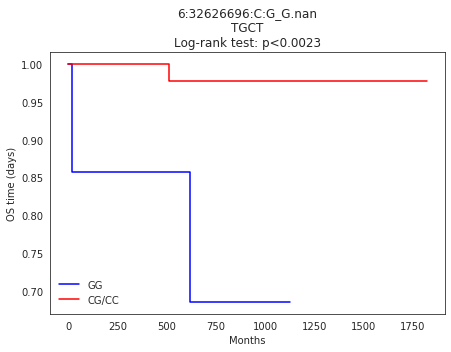

In [57]:
run_surv_plot(os_sig_annot,os_surv,"OS","../plots/kaplan-plots/")

## Progression-free survival

In [58]:
pfi_surv=make_df("/cellar/users/mpagadal/Data/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","PFI","/nrnb/users/mpagadal/tcga-genotypes/germline-immune/immune.snp.raw")

(8183, 478)


In [59]:
pfi_surv["cancer"]=pfi_surv["FID"].map(mp)

In [60]:
rsid_lst=pfi_surv.columns[3:-1]

In [61]:
# make list of cancer types
cancers=pfi_surv["cancer"].unique().tolist()

In [62]:
pfi=run_surv(pfi_surv,"PFI",rsid_lst,cancers)

In [63]:
pfi["sum"]=pfi["min"]+pfi["maj"]
pfi["freq"]=pfi["min"]/pfi["sum"]
pfi_filt=pfi[(pfi["freq"]>.01)&(pfi["min"]>1)]

In [64]:
pfi_fdr=pd.DataFrame()

for x in pfi_filt["cancer"].unique().tolist():
    pfi_cancer=pfi_filt[pfi_filt["cancer"]==x]
    pfi_fdr=pfi_fdr.append(fdr(pfi_cancer,"os.time"))

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [65]:
pfi_sig=pfi_fdr[pfi_fdr["-log10(fdr)"]>1]
pfi_sig["snps"]=pfi_sig["snps"].str.split("_").str[0]

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
pfi_sig.shape

(46, 9)

In [67]:
pfi_sig_annot=pd.merge(pfi_sig,snps[["snps","file"]],on="snps",how="left")

In [68]:
run_surv_plot(pfi_sig_annot,pfi_surv,"PFI","../plots/kaplan-plots/")

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/nrnb/opt/anaconda3.7/lib/python3.7/site-pa

## Plot summary statistics

In [69]:
pfi_mean=pfi_sig_annot[["cancer","-log10(fdr)"]].groupby("cancer").mean()
pfi_count=pfi_sig_annot[["cancer","-log10(fdr)"]].groupby("cancer").size().reset_index().set_index("cancer")
pfi_plot=pd.merge(pfi_mean,pfi_count,right_index=True,left_index=True)

In [70]:
os_mean=os_sig_annot[["cancer","-log10(fdr)"]].groupby("cancer").mean()
os_count=os_sig_annot[["cancer","-log10(fdr)"]].groupby("cancer").size().reset_index().set_index("cancer")
os_plot=pd.merge(os_mean,os_count,right_index=True,left_index=True)

In [71]:
pfi_plot["cat"]="pfi"
os_plot["cat"]="os"

In [72]:
total_plot=pfi_plot.append(os_plot)

In [73]:
total_plot=total_plot.reset_index()

In [74]:
total_plot.to_csv("../data/os.pfi.germline.variants.txt",index=None,sep="\t")

## Plot prognostic snps

In [75]:
plt.figure(figsize=(2,10))
sns.heatmap(total_plot,cmap="Reds",annot=True)
plt.savefig("../plots/prognostic.snps.pdf")

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 144x720 with 0 Axes>

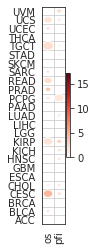

In [37]:


grid=total_plot.pivot(index="cancer", columns="cat",values=0)
c=total_plot.pivot(index="cancer", columns="cat",values="-log10(fdr)")

grid=grid.fillna(0)
c=c.fillna(0)

for x in c.columns:
    c[x]=pd.to_numeric(c[x])

ylabels = grid.index.tolist()
xlabels = grid.columns.tolist()
N=len(ylabels)
M=len(xlabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = grid.values
c = c.values

fig, ax = plt.subplots(figsize=(0.5, 4))

R = s/s.max()/2
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Reds")
ax.add_collection(col)

ax.set(xticks=np.arange(len(xlabels)), yticks=np.arange(len(ylabels)),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')
plt.xticks(rotation=90)

fig.colorbar(col)
plt.savefig("../plots/prognostic.snps.pdf")


In [38]:
pfi_sig

,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr)
881,19:52130638:C:A,2.081625e-06,BLCA,4,294,298,0.013423,0.000562,3.250234
1519,3:51623547:C:T,2.999021e-06,CESC,2,150,152,0.013158,0.000762,3.118187
1669,5:96358320:A:G,2.273122e-04,CESC,3,149,152,0.019737,0.019246,1.715665
1756,11:65838991:G:C,2.602152e-05,CESC,2,150,152,0.013158,0.003305,2.480864
2056,5:79811662:A:G,6.392217e-04,CHOL,4,25,29,0.137931,0.047942,1.319287
2201,10:71880791:C:G,4.635257e-04,CHOL,2,27,29,0.068966,0.047942,1.319287
2317,19:52265776:T:G,1.869541e-03,CHOL,5,24,29,0.172414,0.093477,1.029295
2857,1:78716854:T:C,3.551910e-04,ESCA,3,113,116,0.025862,0.084180,1.074790
3703,16:23669290:C:T,9.179532e-05,GBM,14,386,400,0.035000,0.022949,1.639239
3850,1:158786903:C:T,1.304132e-04,HNSC,20,362,382,0.052356,0.017475,1.757574
